In [1]:
import numpy as np
from matplotlib import pyplot as plt
import matplotlib as mpl
from scipy.integrate import solve_ivp

r0 = 5.29e-11

m = 9.1e-31
k = 9e9
q = 1.6e-19

v0 = np.sqrt(k * q**2 / (m * r0))
T = 2 * np.pi * r0 / v0

In [2]:
def calculate_coulomb_force(distance_vec, attract=False):
    mag = k * q ** 2 / np.linalg.norm(distance_vec) ** 3 * distance_vec
        
    # reverse direction if it's attractive
    if attract:
        return mag * -1
    else:
        return mag

In [3]:
def calculate(steps_per, rtol, atol):
    # Set some important parameters
    t_span = (0, 10*T)
    state0 = (r0, 0, 0, v0) # x0, y0, vx0, vy0
    
    def diff_eqns_2(t, state):
        pos = np.array([state[0], state[1]])
        vel = np.array([state[2], state[3]])
        net_force = calculate_coulomb_force(pos, attract=True)
        
        accel = net_force / m
        return [ vel[0], vel[1], accel[0], accel[1] ]

    return solve_ivp(diff_eqns_2, t_span, state0, rtol=rtol, atol=atol)

In [4]:
from dataclasses import dataclass
from PIL import Image
import io

@dataclass
class SimulationResult:
    trajectory: Image
    yvstime: Image
    energy: Image
    speed: Image
    
def simulate(steps_per=None, rtol=None, atol=None):
    def save_graph_and_close():
        buf = io.BytesIO()
        plt.savefig(buf, format='png')
        buf.seek(0)
        graph = Image.open(buf)
        plt.close()
        return graph

    result = SimulationResult(None, None, None, None)

    sol1 = calculate(steps_per, rtol, atol)
    time = sol1.t
    x = sol1.y[0]
    y = sol1.y[1]
    vx = sol1.y[2]
    vy = sol1.y[3]

    plt.figure()
    plt.plot(x, y)
    plt.xlabel('x')
    plt.ylabel('y')
    plt.title(f'Trajectory of 10 orbits')
    plt.grid(True)
    result.trajectory = save_graph_and_close()
    
    plt.figure()
    plt.plot(time, y)
    plt.xlabel('t')
    plt.ylabel('y')
    plt.title(f'y vs. time')
    plt.grid(True)
    result.yvstime = save_graph_and_close()
    
    v = np.sqrt(vx ** 2 + vy ** 2)
    r = np.sqrt(x ** 2 + y ** 2)

    K = 0.5 * m * v ** 2
    U = - k * q ** 2 / r
    E = K + U

    plt.figure()
    plt.plot(time, K, label="Kinetic Energy")
    plt.plot(time, U, label="Potential Energy")
    plt.plot(time, E, label="Total Energy")
    plt.xlabel("Time")
    plt.ylabel("Energy")
    plt.title("Energy vs Time")
    plt.legend()
    plt.grid(True)
    result.energy = save_graph_and_close()
    
    plt.figure()
    plt.plot(time, v)
    plt.xlabel("Time")
    plt.ylabel("Speed")
    plt.title("Speed vs Time")
    plt.legend()
    plt.grid(True)
    result.speed = save_graph_and_close()
    
    return result

In [5]:
result1 = simulate(rtol=1e-9, atol=1e-9)

/tmp/ipykernel_18372/4248158044.py:69: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


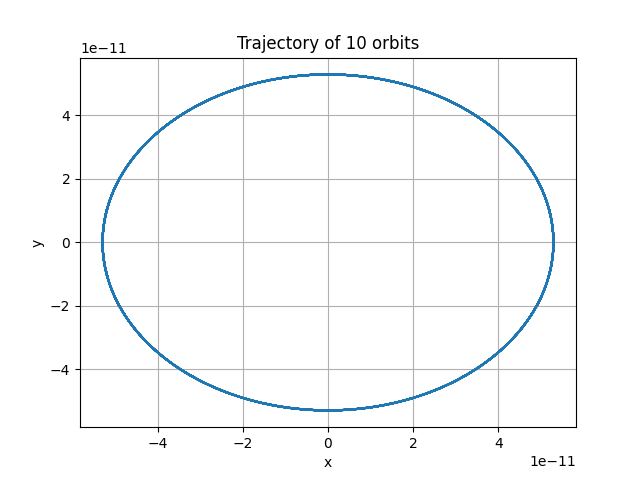

In [6]:
display(result1.trajectory)

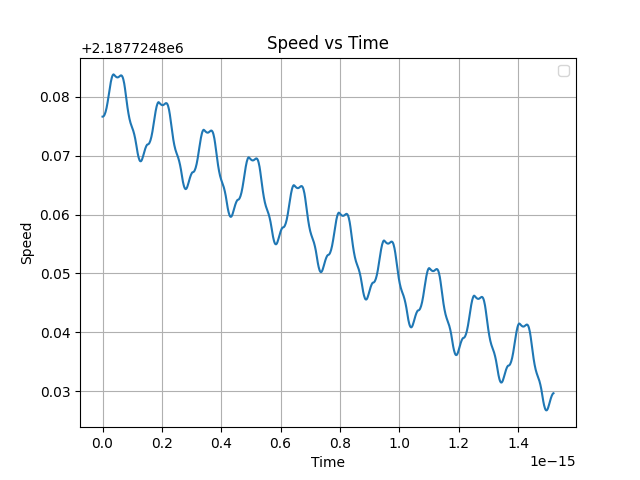

In [7]:
display(result1.speed)

In [9]:
def cartesian_to_polar(coords):
    """
    Convert an array of 2D Cartesian coordinates to polar coordinates.
    coords can be shape (2,) or (2,n)
    Returns an array of shape (2,) or (2, N): [r, theta]
    """
    coords = np.asarray(coords)

    if coords.ndim == 1:
        x, y = coords
        r = np.sqrt(x**2 + y**2)
        theta = np.arctan2(y, x)
        return np.array([r, theta])

    elif coords.ndim == 2 and coords.shape[0] == 2:
        x = coords[0]
        y = coords[1]
        r = np.sqrt(x**2 + y**2)
        theta = np.arctan2(y, x)
        return np.array([r, theta])

    else:
        raise ValueError(f"Expected shape (2,) or (N,2), got {coords.shape}")

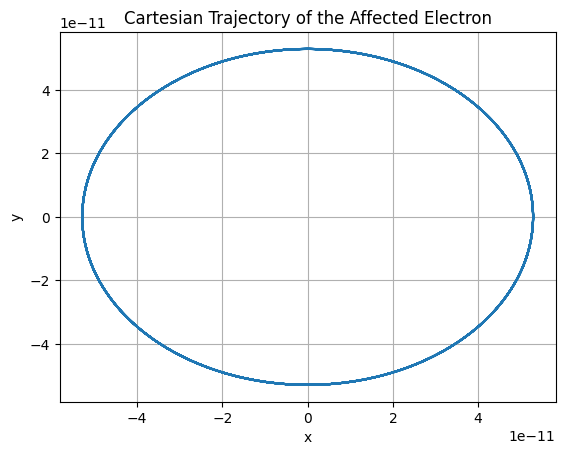

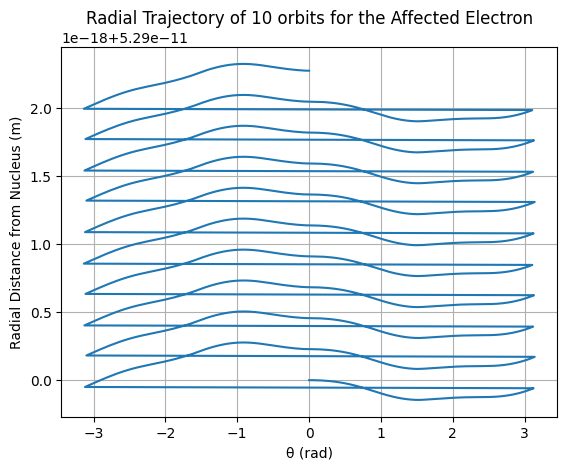

NameError: name 'magnitudes' is not defined

<Figure size 640x480 with 0 Axes>

In [10]:
def test_calculation_raw():
    trivial_state = (r0, 0, 0, v0)
    T = 2 * np.pi * r0 / v0   # ensure same as in calculate()
    
    def diff_eqns(t, state):
        pos = np.array([state[0], state[1]])
        vel = np.array([state[2], state[3]])
        net_force = calculate_coulomb_force(pos, attract=True)
        
        accel = net_force / m
        return [ vel[0], vel[1], accel[0], accel[1] ]
    
    calculation = solve_ivp(diff_eqns, (0, 10*T), trivial_state, rtol=1e-9, atol=1e-9)
    pos = np.array([calculation.y[0], calculation.y[1]])
    vel = np.array([calculation.y[2], calculation.y[3]])
    radial_pos = cartesian_to_polar(pos)
    
    plt.figure()
    plt.plot(pos[0], pos[1])
    plt.xlabel('x')
    plt.ylabel('y')
    plt.title(f'Cartesian Trajectory of the Affected Electron')
    plt.grid(True)
    plt.show()
    
    plt.figure()
    plt.plot(radial_pos[1], radial_pos[0])
    plt.xlabel('θ (rad)')
    plt.ylabel('Radial Distance from Nucleus (m)')
    plt.title(f'Radial Trajectory of 10 orbits for the Affected Electron')
    plt.grid(True)
    plt.show()
    
    plt.figure()
    plt.plot(calculation.t, magnitudes(vel.transpose()))
    plt.xlabel('Time (s)')
    plt.ylabel('Speed (m/s)')
    plt.title(f'Speed vs. Time')
    plt.grid(True)
    plt.show()
    
test_calculation_raw()